`pyspc-unmix`: Python package for unmixing hyperspectral data
==============

<!-- badges: start -->
[![Project Status: WIP – Initial development is in progress, but there has not yet been a stable, usable release suitable for the public.](https://www.repostatus.org/badges/latest/wip.svg)](https://www.repostatus.org/#wip)
<!-- badges: end -->

# Installation

```bash
pip install git+https://github.com/r-hyperspec/pyspc-unmix
```


# Available tools and alogrithms

* Endmember extraction:
    * **N-FINDR**
* Decomposition - helper classes and transformations for representing data as linear decomposition, i.e. $X = C \times S$
    * **OLS** (Ordinary Least Squares) - most common linear decomposition $X = C \times S$;
    * **NNLS** (Non-negative Least Squares) - linear decomposition with non-negative constraints $X = C \times S$, $C \geq 0$;
    * **Barycentric coordinates** - given a simplex vertices, transform points to barycentric coordinates and vice versa;
    * **PCA** (Principal Component Analysis);
    * **EMSC** Extended Multiplicative Signal Correction.


# Examples

## Prepare pure-mixture dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

from pyspc_unmix.utils import generate_demo_mixture

# Simulate mixtures
mixtures, true_coefs, true_ems, x = generate_demo_mixture()

This is how true coefficients look like


In [2]:
pd.DataFrame(true_coefs, columns=["EM1", "EM2", "EM3"])

,EM1,EM2,EM3
0,0.182059,0.462129,0.355812
1,0.657381,0.171323,0.171296
2,0.038078,0.567845,0.394077
3,0.416865,0.012119,0.571017
4,0.678655,0.173111,0.148234
...,...,...,...
95,0.025000,0.025000,0.950000
96,0.315618,0.650787,0.033595
97,0.030610,0.674186,0.295205
98,0.089524,0.367959,0.542517


Plot simulated mixtures and pure components


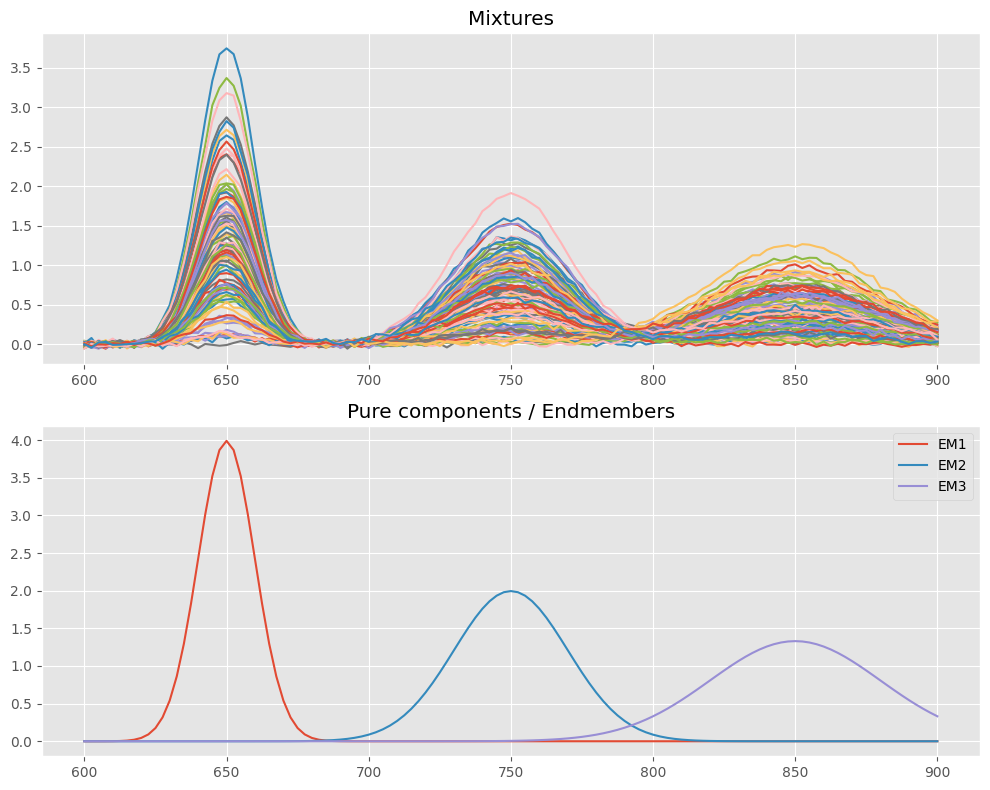

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="tight")
axs[0].plot(x, mixtures.T)
axs[1].plot(x, true_ems.T, label=["EM1", "EM2", "EM3"])
axs[0].set_title("Mixtures")
axs[1].set_title("Pure components / Endmembers")
axs[1].legend()

## Decompositions

Decomposition classes are a convenient way to represent data as a linear decomposition, i.e. $X = C \times S$. The most commonly used `scikit-leart` transform interface is powerful but approaches the problem from a transformation perspective. These classes approach the problem from a data representation perspective. So, it helps to:
* _keep loadings and scores together:_ Working with a decomposed spectral data, it is common to work with _loadings_ and _scores_, and it is often conviniet to 'have them near each other'. 
* _have the same interface for different algorithms:_ Another inconvinience is different naming conventions for the same, from the decomposition perspective, _loadings_ and _scores_ matrices.
* _treat loadings as a dimension that can be sliced:_ Working with spectral data, it is common to manipulate the components (_loadings_), e.g. picking or excluding specific PCs or reconstructing background in EMSC. Therefore, it is convinient to be able to slice the loadings dimenstion as if it was another dimension.

### Notations

* $n\_samples, n\_features, n\_components$ - number of samples, features (wavelengths) and components (loadings or endmembers), respectively.
* $X \in \mathbb{R}^{n\_samples \times n\_features}$ - original data matrix, where rows are samples and columns are features (wavelengths).
* $S \in \mathbb{R}^{n\_components \times n\_features}$ - loadings matrix, where rows are components (endmembers) and columns are features (wavelengths).
* $C \in \mathbb{R}^{n\_samples \times n\_components}$ - scores matrix, where rows are samples and columns are components (endmembers).
* $D \in \mathbb{R}^{n\_samples \times n\_features}$ - recunstructions matrix (i.e. $ D = C \times S$), where rows are samples and columns are features (wavelengths).
* $E \in \mathbb{R}^{n\_samples \times n\_features}$ - residuals matrix (i.e. $ E = X - D$), where rows are samples and columns are features (wavelengths).
* Therefore, the decomposition can be represented as $X = C \times S + E$.
* Notation $D = C \times S$ is adopted from MCR-ALS literature, it can be cosidered as D - data, C - components/coefficients, S - spectra.
* Terminology might be mixed in some places:
   * abundances/coefficients/contributions/scores - all refer to $C$,
   * endmembers/loadings/components/pure components - all refer to $S$,
   * features/wavelengths/bands - all refer to columns of $X$,
   * samples/spectra - all refer to rows of $X$.

### Decomposition: OLS and Basics

In [4]:
from pyspc_unmix.decomposition import LinearDecomposition

dec = LinearDecomposition(true_ems, true_coefs)

`LinearDecomposition` is a base class for all decompositions. Each decomposition has following attributes:
* `loadings` - a matrix of shape `(n_components, n_features)` representing the components; for short, can be also accessed as `S`;
* `scores` - a matrix of shape `(n_samples, n_components)` representing the scores; for short, can be also accessed as `C`;
* `tranformer` - a transformer object that has `transform` and `inverse_transform` methods. Note that `fit` is not part of the decomposition. OLS (Ordinary Least Squares) transformer is used by default.;
* `names` - a list of names for the components, i.e. "PC" for PCA, "EMSC" for EMSC, etc.

In [5]:
dec.loadings.shape

(3, 121)

In [6]:
dec.scores.shape

(100, 3)

In [7]:
dec.names

array(['Comp1', 'Comp2', 'Comp3'], dtype='<U5')

In [8]:
dec.transformer

### Decompostion: PCA

In [9]:
from pyspc_unmix.decomposition import PCADecomposition

# Decompose mixtures using PCA tranformer from scikit-learn
# now loadings and scores are available as `pca.loadings`
# and `pca.scores`.
noisy_mixtures = mixtures + np.random.normal(0, 0.1, mixtures.shape)
pca = PCADecomposition(noisy_mixtures, n_components=15)

In [10]:
# Shape shows <n_samples, n_components, n_features>
pca.shape

(100, 15, 121)

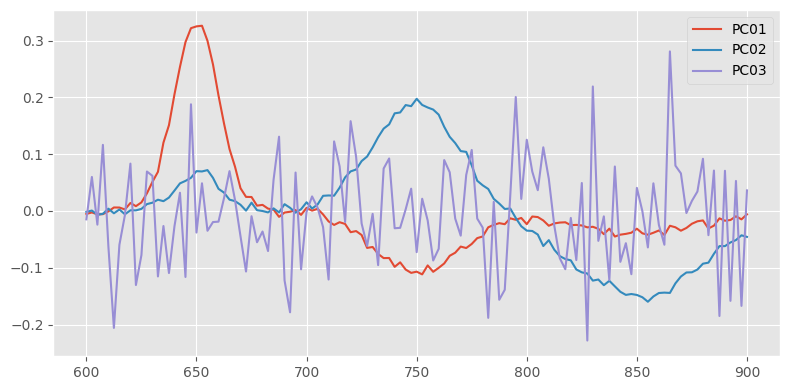

In [11]:
# Show some of the loadings
fig, ax = plt.subplots(figsize=(8, 4), layout="tight")
ax.plot(x, pca.loadings[:3,:].T, label=pca.names[:3])
_ = ax.legend()

Text(0, 0.5, 'PC02')

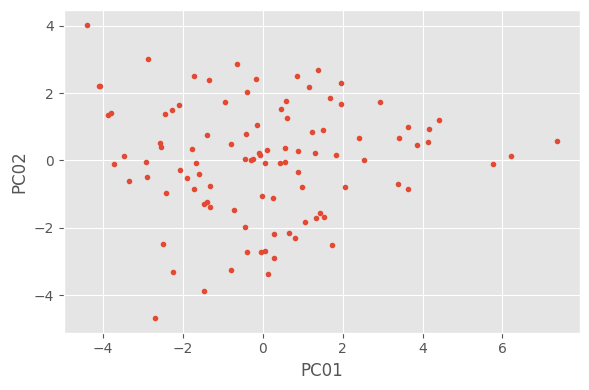

In [12]:
# Show the scores
# NOTE: That names are padded with zeros to have the same length
# and to be correctly sorted in plots.
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")
ax.plot(pca.scores[:, 0], pca.scores[:, 1], ".")
ax.set_xlabel(pca.names[0])
ax.set_ylabel(pca.names[1])

In [13]:
# Access the transformer object
pca.transformer.explained_variance_ratio_

array([0.57335114, 0.30139144, 0.00446004, 0.0041854 , 0.00392623,
       0.00386649, 0.0037641 , 0.0036667 , 0.00353652, 0.00343771,
       0.00342046, 0.00326752, 0.00305559, 0.00301493, 0.00296558])

Spectral reconstruction, i.e. (scores x loadings), can be accessed as `reconstructions` attribute (or "D" for short).
Note that **three** values are passed for slicing a decompostion object: slicing samples/measurements, slicing components (PCs in this case), and slicing features, i.e `pca[i,:k,l:]` returns a PCA decomposition where scores are reduced to `i`-th sample, only first `k` PCs are used, and first `l` features (wavelengths) are skipped.

Note that `pca[i, :k, l:].reconstrunctions` is equivalent to `pca[:, :k, :].reconstructions[i, l:]`. However, the former is more efficeint as it slices the data before reconstruction, while the latter first reconstructs the whole data and then slices it.

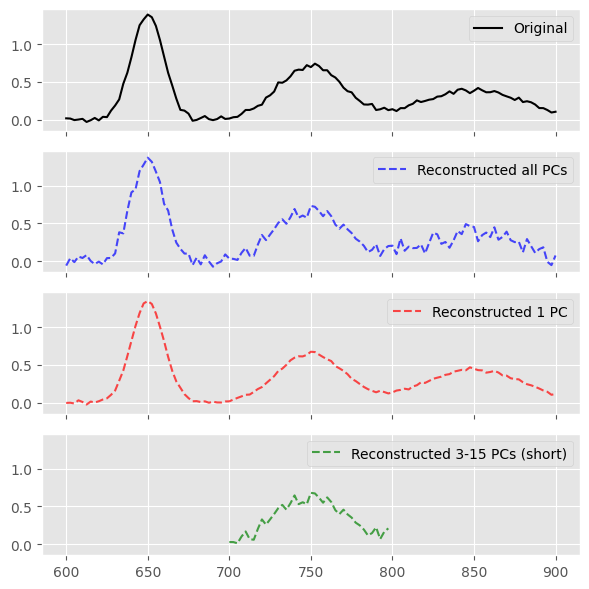

In [14]:
# Reconstruction and slicing
fig, axs = plt.subplots(4, 1, figsize=(6, 6), layout="tight", sharex=True, sharey=True)
i = 11
axs[0].plot(x, mixtures[i,:], "k-", alpha=1, label="Original")
axs[1].plot(x, pca[i,:,:].D, "b--", alpha=0.7, label="Reconstructed all PCs")
axs[2].plot(x, pca[i,:1,:].D.T, "r--", alpha=0.7, label="Reconstructed 1 PC")
axs[3].plot(x[40:80], pca[i, 2:, 40:80].D.T, "g--", alpha=0.7, label="Reconstructed 3-15 PCs (short)")
for ax in axs:
    ax.legend()

### Decomposition: NNLS

In [15]:
from pyspc_unmix.decomposition import NNLSDecomposition

# Decompose mixtures using NNLS
# For this the loadings have to be explicitly provided.
nnls = NNLSDecomposition(noisy_mixtures, ems=true_ems, names="EM")

Text(0, 0.5, 'EM2')

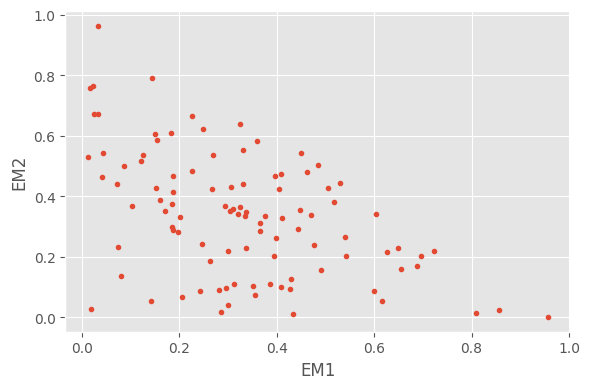

In [16]:
# Now the same interface can be used to access the loadings and scores
fig, ax = plt.subplots(figsize=(6, 4), layout="tight")
ax.plot(nnls.scores[:, 0], nnls.scores[:, 1], ".")
ax.set_xlabel(nnls.names[0])
ax.set_ylabel(nnls.names[1])

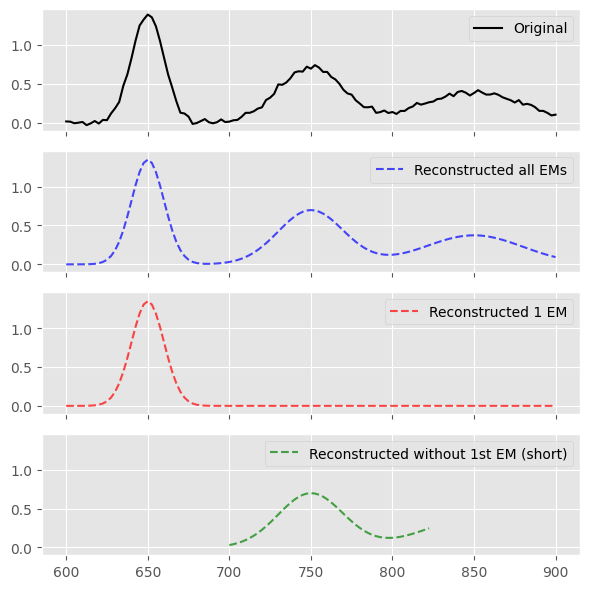

In [17]:
# Similarly, reconstruction and slicing can be done
fig, axs = plt.subplots(4, 1, figsize=(6, 6), layout="tight", sharex=True, sharey=True)
i = 11
axs[0].plot(x, mixtures[i,:], "k-", alpha=1, label="Original")
axs[1].plot(x, nnls[i,:,:].D, "b--", alpha=0.7, label="Reconstructed all EMs")
axs[2].plot(x, nnls[i,:1,:].D.T, "r--", alpha=0.7, label="Reconstructed 1 EM")
axs[3].plot(x[40:90], nnls[i, 1:, 40:90].D.T, "g--", alpha=0.7, label="Reconstructed without 1st EM (short)")
for ax in axs:
    ax.legend()

### Decomposition: EMSC

Although EMSC it is not intuitive to think about EMSC as $X = C \times S$ decomposition, in practice, it is implemented as such with just slightly adjusted $S$ matrix that includes other components such as polynomials. Therefore, it might be convinient to think about EMSC in terms of decomposition and components slicing.

In [18]:
from pyspc_unmix.decomposition import EMSCDecomposition, vandermonde

# Add random polynomial baseline to mixtures
degree = 4  # Degree of the polynomial

# Generate polynomial background
np.random.seed(42)  # For reproducibility
poly_background = 10*np.random.randn(mixtures.shape[0], degree + 1) @ vandermonde(x, degree)
# Normalize to [0, 2]
poly_background -= poly_background.min(axis=1)[:, None]
poly_background /= 0.5*poly_background.max(axis=1)[:, None]

# Add polynomial background to mixtures
poly_mixtures = mixtures + poly_background

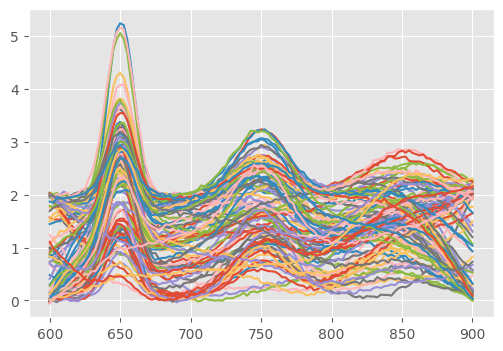

In [19]:
# Plot poly_mixtures
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.plot(x, poly_mixtures.T)

In [20]:
emsc = EMSCDecomposition(poly_mixtures, ems=true_ems, p=degree, wl=x, names="EMSC")

In [21]:
emsc.names

array(['EMSC1', 'EMSC2', 'EMSC3', 'Poly0', 'Poly1', 'Poly2', 'Poly3',
       'Poly4'], dtype='<U5')

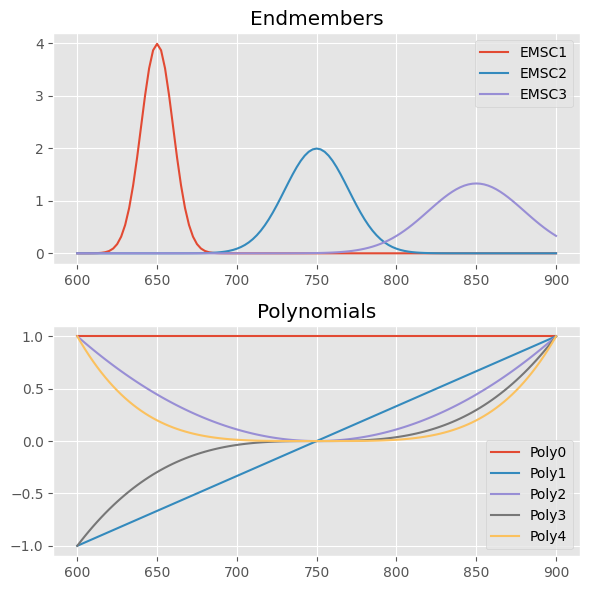

In [22]:
# Polynomials are included as loadings but have different names
fig, axs = plt.subplots(2, 1, figsize=(6, 6), layout="tight")
axs[0].plot(x, emsc.loadings[:len(true_ems)].T, label=emsc.names[:len(true_ems)])
axs[0].set_title("Endmembers")
axs[1].plot(x, emsc.loadings[len(true_ems):].T, label=emsc.names[len(true_ems):])
axs[1].set_title("Polynomials")
for ax in axs:
    ax.legend()

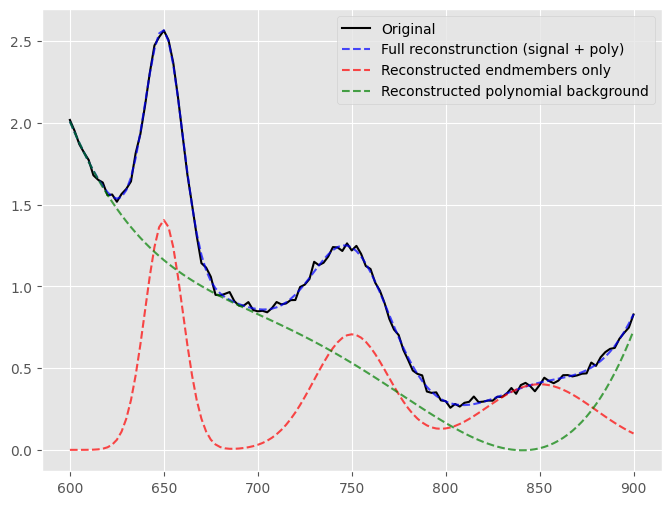

In [23]:
# Slicing can be especially useful for EMSC
fig, ax = plt.subplots(figsize=(8, 6))
i = 11
ax.plot(x, poly_mixtures[i,:], "k-", alpha=1, label="Original")
ax.plot(x, emsc[i,:,:].D, "b--", alpha=0.7, label="Full reconstrunction (signal + poly)")
ax.plot(x, emsc[i,:len(true_ems),:].D.T, "r--", alpha=0.7, label="Reconstructed endmembers only")
ax.plot(x, emsc[i,len(true_ems):,:].D.T, "g--", alpha=0.7, label="Reconstructed polynomial background")
_=ax.legend()

In [24]:
# EMSC correction can be applied via reconstructions and slicing as well
# Let's say we are interested only in the first endmember and the rest
# (i.e. 2nd and 3rd endmember and polynomials) should be removed
corr_mixtures = poly_mixtures - emsc[:, 1:, :].D

# And if we want to normalize to the concentration of the first endmember
corr_mixtures_norm = corr_mixtures / emsc.scores[:, [0]]

Text(0.5, 1.0, 'Corrected and normalized spectra')

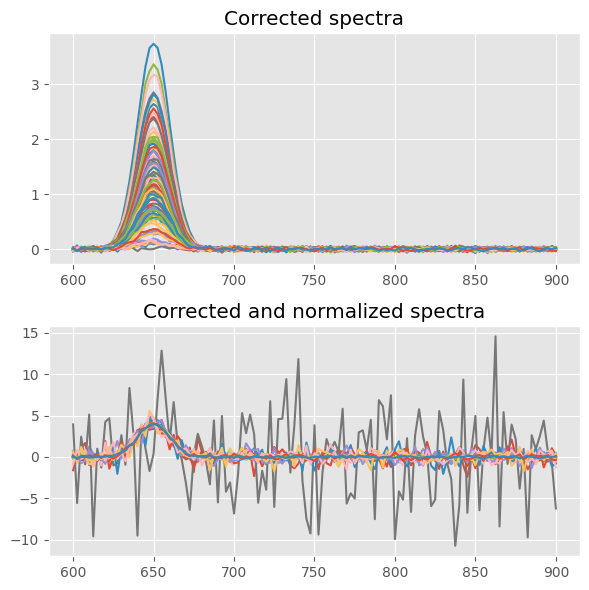

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), layout="tight")
axs[0].plot(x, corr_mixtures.T)
axs[0].set_title("Corrected spectra")
axs[1].plot(x, corr_mixtures_norm.T)
axs[1].set_title("Corrected and normalized spectra")

### Decomposition: Barycentric coordinates

Is geometry based unmixing, it is useful sometimes to represent data in barycentric coordinates. This is especially useful when working with pure pixel endmember extraction algorithms such as N-FINDR. Barycentric coordinates can be used to transform points to barycentric coordinates and vice versa.

In [26]:
from pyspc_unmix.decomposition import BaryDecomposition

# Decompose mixtures using Barycentric decomposition
# NOTE: Barycentric docomposition requires that n_features is
# equal to n_components - 1. Therefore, in practice, its applied
# to dimension reduced data.
bary = BaryDecomposition(pca.scores[:,:2], ems=pca.transform(true_ems)[:, :2], names="EM")

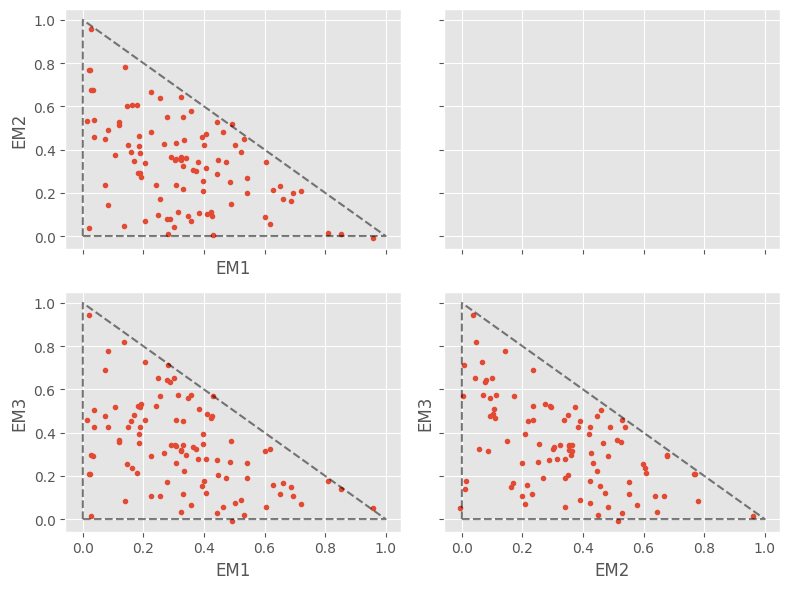

In [27]:
# Now bary.scores represent the barycentric coordinates.
# The values in rows sum to 1. However, they are not constrained to
# be positive.  Few points outside of the triange have negative contributions.
fig, axs = plt.subplots(2,2, figsize=(8, 6), layout="tight", sharex=True, sharey=True)
for j in range(axs.shape[1]):
    for i in range(j, axs.shape[0]):
        axs[i,j].plot(bary.scores[:, j], bary.scores[:, i+1], ".")
        axs[i,j].set_xlabel(bary.names[j])
        axs[i,j].set_ylabel(bary.names[i+1])
        axs[i,j].plot([0, 1, 0, 0], [0, 0, 1, 0], "k--", alpha=0.5)


::: {.callout-note}
For more advanced plots of barycentric coordinates consider ternary plots and packages such as [python-ternary](https://github.com/marcharper/python-ternary), [mpltern](https://mpltern.readthedocs.io/en/latest/), `scatter_ternary` from [plotly](https://plotly.com/python/ternary-plots/).

:::

## N-FINDR

### N-FINDR: Basic example


In [28]:
%%capture
from sklearn.decomposition import PCA
from pyspc_unmix import NFINDR

# First, reduce dimension with PCA
pca_scores = PCA(n_components=2).fit_transform(mixtures)

# Apply NFINDR to find pure components and the concentrations
# Set random state for reproducible results
nf = NFINDR(n_endmembers=3, random_state=21)
nf.fit(pca_scores)

In [29]:
# Check found endmembers
pd.DataFrame(true_coefs[nf.endmember_indices_, :], columns=["EM1", "EM2", "EM3"])

,EM1,EM2,EM3
0,0.950,0.025,0.025
1,0.025,0.950,0.025
2,0.025,0.025,0.950


In [30]:
# Endmember coordinates in the reduced PCA space
pd.DataFrame(nf.endmembers_, columns=["PC1", "PC2"])

,PC1,PC2
0,7.213701,0.845328
1,-4.371155,3.944780
2,-2.583558,-4.753258


In [31]:
# Calculate the abundances (coefficients) for the mixtures
nfindr_coefs = nf.transform(pca_scores)

c:\Users\gulievrustam\venvs\pyspc_unmix\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [32]:
# The values correspond to true concentrations
pd.DataFrame(nfindr_coefs, columns=["EM1", "EM2", "EM3"])

,EM1,EM2,EM3
0,0.169017,0.471370,0.359613
1,0.687749,0.159079,0.153172
2,0.012803,0.581617,0.405579
3,0.425307,-0.015681,0.590373
4,0.707065,0.158262,0.134673
...,...,...,...
95,0.000000,0.000000,1.000000
96,0.313005,0.672871,0.014124
97,0.003540,0.699878,0.296582
98,0.068655,0.368628,0.562718


### N-FINDR: Function interface

It is also possible to use a function interface for N-FINDR algorithm.
However, in this case, only the indices of the "pure pixels" (endmembers) are returned.

::: {.callout-note}
If future, it is planned to switch to the function interface for all endmember extraction algorithms. This is to avoid a general misconception that abundances/coefficitents are output of the algorithm. Also, to be explicit about the abunances calculation. So, the future workflow will be 1) extract endmembers or their indices using a function; 2) use `BaryDecomposition` or `NNLSDecomposition` to calculate abundances.

:::


In [33]:
from pyspc_unmix import nfindr

nfindr(pca_scores[:, :2])

[15, 41, 95]

In [34]:
# The above is simply the same as `nf.endmember_indices_`
nf.endmember_indices_

[15, 41, 95]

### N-FINDR: Pipline interface


In [35]:
%%capture
from sklearn.pipeline import Pipeline

p=3
pca_nfindr_pipe = Pipeline([('pca', PCA(n_components=p-1)), ('nfindr', NFINDR(n_endmembers=p, random_state=21))])
nfindr_pip_coefs = pca_nfindr_pipe.fit_transform(mixtures)

In [36]:
# Get the same results as in the previous example
pd.DataFrame(nfindr_pip_coefs, columns=["EM1", "EM2", "EM3"])

,EM1,EM2,EM3
0,0.169017,0.471370,0.359613
1,0.687749,0.159079,0.153172
2,0.012803,0.581617,0.405579
3,0.425307,-0.015681,0.590373
4,0.707065,0.158262,0.134673
...,...,...,...
95,0.000000,0.000000,1.000000
96,0.313005,0.672871,0.014124
97,0.003540,0.699878,0.296582
98,0.068655,0.368628,0.562718


### NFINDR: Out-of-simplex points and Barycentric vs. NNLS

Using NFINDR algorithm one should take care of the points out of the simplex since in
real-world application the data rarely looks like a perfect simplex. In the following
examples it will be demonstrated how the two availalbe transformations (barycentric
and NNLS) behave in those cases.


In [37]:
# Prepare a simple simplex and points to unmix
vertices = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
])
new_points = np.array([
    [0.2, 0.3],  # Inside of the simplex
    [5.0, 5.0],  # Outside of the simplex
])

# Apply NFINDR
nf = NFINDR().fit(vertices)

c:\Users\gulievrustam\venvs\pyspc_unmix\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [38]:
# Transform with Barycentric (default)
# The total sum of contrations/coefficients is always 1. Howerver,
# The coefficients are not in the range [0,1], if a point is outside of the simplex.
nf.transform(new_points, method="barycentric")

c:\Users\gulievrustam\venvs\pyspc_unmix\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


array([[ 0.5,  0.2,  0.3],
       [-9. ,  5. ,  5. ]])

In [39]:
# Transform with NNLS
# Each coefficient is always non-negative. Howerver,
# it does not have to be less than 1. Also, the total sum
# is NOT always equal to 1.
nf.transform(new_points, method="nnls")

c:\Users\gulievrustam\venvs\pyspc_unmix\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


array([[0. , 0.2, 0.3],
       [0. , 5. , 5. ]])

Currently, there is not clear way of dealing with out-of-simplex points.
However one of workarounds can be application of NNLS and normalizing to row sums
(see the example below). This approach allows to keep all concentrations in
range [0, 1] with total sum of 1. However, one should always take into account
that such transformation increases the error of restoring data and does not
necesseray prepresent the true coefficients as barycentric coordinates.  


In [40]:
# The values were normalized to sum-to-one
nnls_concentrations = nf.transform(new_points, method="nnls")
nnls_concentrations /= nnls_concentrations.sum(1).reshape(len(nnls_concentrations), -1)
print(nnls_concentrations)

[[0.  0.4 0.6]
 [0.  0.5 0.5]]


c:\Users\gulievrustam\venvs\pyspc_unmix\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
